# <img style="float: left; padding-right: 10px; width: 45px" src="fig/iacs.png"> S-109A Introduction to Data Science 
## Homework 3 - Forecasting Bike Sharing Usage


<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Classroom.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
from IPython.core.display import HTML
def css_styling():
    styles = open("style/cs109.css", "r").read()
    return HTML(styles)
css_styling()

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>

### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. You will prepare a small report for them.

The hourly demand information would be useful in planning the number of bikes that need to be available in the system on any given hour of the day, and also in monitoring traffic in the city. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore techniques for subset selection. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on attributes about the hour and the day. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).


### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will add some features that will help us with the analysis and then separate it into training and test sets. Each row in this file contains 12 attributes and each entry represents one hour of a 24-hour day with its weather, etc, and the number of rental rides for that day divided in categories according to if they were made by registered or casual riders. Those attributes are the following:

- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1: Explore how Bike Ridership varies with Hour of the Day </b> </div>

#### Learn your Domain and Perform a bit of Feature Engineering

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011 and 1 for 2012.
- `month` with 1 through 12, with 1 denoting Jan. 
- `counts` with the total number of bike rentals for that day (this is the response variable for later).

**1.4** Use visualization to inspect and comment on how **casual** rentals and **registered** rentals vary with the `hour`. 

**1.5** Use the variable `holiday` to show how **holidays** affect the relationship in question 1.4.  What do you observe? 

**1.6** Use visualization to show how **weather** affects **casual** and **registered** rentals. What do you observe? 

### Answers

#### 1.1 Load the dataset from the csv file  ...

In [3]:
# your code here

bikes_df = pd.read_csv('data/BSS_hour_raw.csv', parse_dates=['dteday'])
bikes_df.sample(5)

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
6174,2011-09-19,3,20,0,1,1,2,0.56,0.5303,0.68,0.1343,27,204
6302,2011-09-25,4,4,0,0,0,3,0.60,0.5152,0.94,0.1343,3,5
12349,2012-06-03,2,18,0,0,0,1,0.70,0.6364,0.34,0.2537,153,343
13474,2012-07-20,3,15,0,5,1,2,0.70,0.6667,0.84,0.2985,47,169
7692,2011-11-22,4,3,0,2,1,3,0.38,0.3939,1.00,0.1045,1,2


In [4]:
bikes_df.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


In [5]:
bikes_df.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

In [6]:
print(np.min(bikes_df.dteday))
print(np.mean(bikes_df.dteday))
print(np.max(bikes_df.dteday))

2011-01-01 00:00:00
2012-01-02 04:08:34.552045568
2012-12-31 00:00:00


<HR>
    
`season` makes sense because its min is 1, its max is 4 and its mean is 2.5, suggesting data is distributed all seasons equally. The same for `hour`, `weekday` and `dteday`. For `holiday`, the min is 0 and the max is 1. It's mean is around 0.03, what  suggests data is distributed between few holidays and many non-holidays. The same for `workingday` and `weather`. For `temp`, `atemp`, `hum` and `windspeed`, data seems to be normalized, that is, between 0 and 1. The number of rides (`casual` and `registered`) also seems reasonable.
    
All data types make sense. They're all quantitative.    
<HR>

#### 1.2 Notice that the variable in column ....

In [7]:
# your code here

# It's easier to do this direct with read_csv, as already done.

#### 1.3 Create three new columns ...

In [8]:
# your code here

bikes_df['year'] = bikes_df.dteday.dt.year.apply(lambda x: 0 if x == 2011 else 1)
bikes_df['month'] = bikes_df.dteday.dt.month
bikes_df['counts'] = bikes_df.casual + bikes_df.registered
bikes_df.sample(5)

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
3586,2011-06-03,2,8,0,5,1,2,0.56,0.5303,0.43,0.3284,31,471,0,6,502
11406,2012-04-25,2,11,0,3,1,1,0.52,0.5000,0.32,0.1343,42,177,1,4,219
3385,2011-05-25,2,23,0,3,1,1,0.64,0.6061,0.73,0.1343,12,74,0,5,86
209,2011-01-10,1,0,0,1,1,1,0.12,0.1212,0.50,0.2836,2,3,0,1,5
6693,2011-10-11,4,11,0,2,1,2,0.60,0.5909,0.73,0.1642,31,92,0,10,123


#### 1.4 Use visualization to inspect and comment on how casual rentals and registered rentals vary with the hour. 

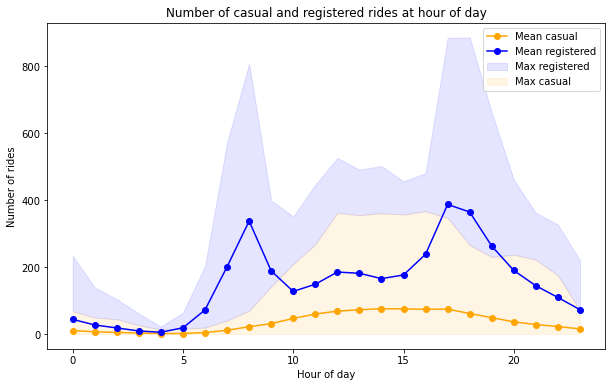

In [9]:
# your code here

casual_mean = bikes_df[['hour', 'casual']].groupby('hour').mean()
casual_max = bikes_df[['hour', 'casual']].groupby('hour').max()
registered_mean = bikes_df[['hour', 'registered']].groupby('hour').mean()
registered_max = bikes_df[['hour', 'registered']].groupby('hour').max()

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(
    registered_max.index,
    registered_max.registered,
    casual_max.casual,
    alpha=0.1,
    color='blue',
    label='Max registered'
)
ax.fill_between(
    casual_max.index,
    casual_max.casual,
    alpha=0.1,
    color='orange',
    label='Max casual'
)
ax.plot(
    casual_mean.index,
    casual_mean.casual,
    marker='o',
    color='orange',
    label='Mean casual'
)
ax.plot(
    registered_mean.index,
    registered_mean.registered,
    marker='o',
    color='blue',
    label='Mean registered'
)
ax.legend()
ax.set_title('Number of casual and registered rides at hour of day')
ax.set_xlabel('Hour of day')
ax.set_ylabel('Number of rides')
plt.show()

<HR>
Both registered and casual curves share the same trend: rides begin in the morning, increase until afternoon, decreases at night and almost vanish at dawn. Despite this, registered rides have peaks in the beggining of the morning and at the end of afternoon. One hypothesis for this is because these are commuting time, that is, time of day where people are going to (or coming back from) work or school. Maybe it affects only registered rides because people who use bike to commute in general is registered: it's cheaper to ride bike everyday if you are registered.<HR>

#### 1.5 Use the variable holiday to show how holidays affect the relationship in question 1.4. What do you observe?

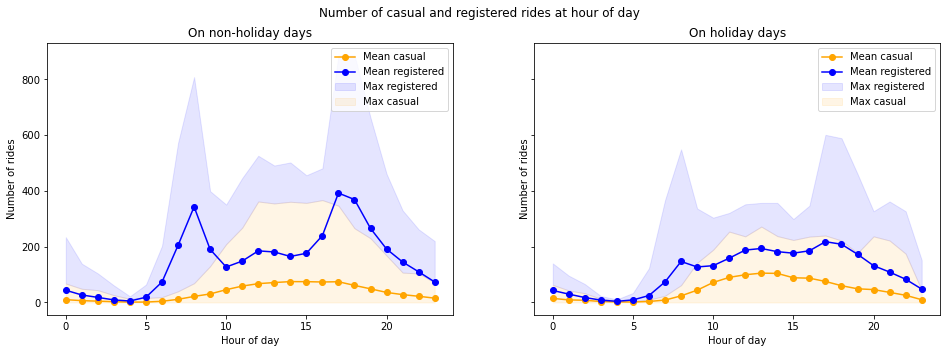

In [10]:
# your code here

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True, sharey=True)

for holiday in range(2):

    casual_mean = bikes_df[bikes_df.holiday == holiday][['hour', 'casual']].groupby('hour').mean()
    casual_max = bikes_df[bikes_df.holiday == holiday][['hour', 'casual']].groupby('hour').max()
    registered_mean = bikes_df[bikes_df.holiday == holiday][['hour', 'registered']].groupby('hour').mean()
    registered_max = bikes_df[bikes_df.holiday == holiday][['hour', 'registered']].groupby('hour').max()
    axes[holiday].fill_between(
        registered_max.index,
        registered_max.registered,
        casual_max.casual,
        alpha=0.1,
        color='blue',
        label='Max registered'
    )
    axes[holiday].fill_between(
        casual_max.index,
        casual_max.casual,
        alpha=0.1,
        color='orange',
        label='Max casual'
    )
    axes[holiday].plot(
        casual_mean.index,
        casual_mean.casual,
        marker='o',
        color='orange',
        label='Mean casual'
    )
    axes[holiday].plot(
        registered_mean.index,
        registered_mean.registered,
        marker='o',
        color='blue',
        label='Mean registered'
    )
    axes[holiday].legend()
    if not holiday:
        axes[0].set_title('On non-holiday days')
    else:
        axes[1].set_title('On holiday days')
    axes[holiday].set_xlabel('Hour of day')
    axes[holiday].set_ylabel('Number of rides')
    
fig.suptitle("Number of casual and registered rides at hour of day")
plt.show()

<HR>
    Both curves still share the same trends. However, it seems casual rides increase, maybe because recreation during holidays, and the peaks of registered rides decrease, most likely because less people is working during these days. We also see that in both curves there's a peak in max rides (the max number of rides at that hour of day) during the night (around 21:00), which doesn't appear on non-holiday days. It doesn't seem to affect the mean, maybe it's a specific day or set of days.<BR>
<HR>

#### 1.6  Use visualization to show how weather affects casual and registered rentals. What do you observe?

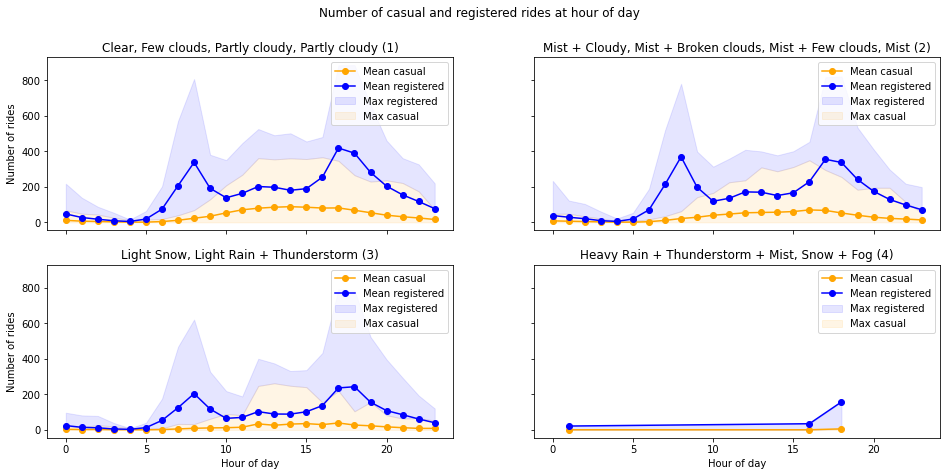

In [11]:
# your code here

fig, axes = plt.subplots(2, 2, figsize=(16, 7), sharex=True, sharey=True)

for weather in range(1, 5):    
    ax = axes.reshape(-1)[weather-1]

    casual_mean = bikes_df[bikes_df.weather == weather][['hour', 'casual']].groupby('hour').mean()
    casual_max = bikes_df[bikes_df.weather == weather][['hour', 'casual']].groupby('hour').max()
    registered_mean = bikes_df[bikes_df.weather == weather][['hour', 'registered']].groupby('hour').mean()
    registered_max = bikes_df[bikes_df.weather == weather][['hour', 'registered']].groupby('hour').max()
    ax.fill_between(
        registered_max.index,
        registered_max.registered,
        casual_max.casual,
        alpha=0.1,
        color='blue',
        label='Max registered'
    )
    ax.fill_between(
        casual_max.index,
        casual_max.casual,
        alpha=0.1,
        color='orange',
        label='Max casual'
    )
    ax.plot(
        casual_mean.index,
        casual_mean.casual,
        marker='o',
        color='orange',
        label='Mean casual'
    )
    ax.plot(
        registered_mean.index,
        registered_mean.registered,
        marker='o',
        color='blue',
        label='Mean registered'
    )
    ax.legend()
    
    if weather == 1:
        ax.set_title('Clear, Few clouds, Partly cloudy, Partly cloudy ({})'.format(weather))
    elif weather == 2:
        ax.set_title('Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ({})'.format(weather))
    elif weather == 3:
        ax.set_title('Light Snow, Light Rain + Thunderstorm ({})'.format(weather))
    elif weather == 4:
        ax.set_title('Heavy Rain + Thunderstorm + Mist, Snow + Fog ({})'.format(weather))

    if weather in [3, 4]:
        ax.set_xlabel('Hour of day')
    if weather in [1, 3]:
        ax.set_ylabel('Number of rides')
    
fig.suptitle("Number of casual and registered rides at hour of day")
plt.show()

<HR>
Let's compare the graphs with the first one (the one with clear sky or with clouds). It seems mist makes casual curve decrease, but it doesn't affect registered curve. Maybe it's because registered rides is most likely associated with people who needs the bike to get to work or home, and casual is most likely to be associated with recreation. Snow, rain and thunderstorm make both curves to decrease. But they still seem to share the same trend and peaks. For the graph 4, we don't have enough data. It's possibly because people don't ride bikes in adverse climate conditions, but we can't discard dataset problems too.
<HR>

<div class='exercise'> <b> Question 2: Explore Seasonality on Bike Ridership. </b></div>

#### Seasonality and weather

Now let's examine the effect of weather and time of the year. For example, you want to see how ridership varies with season of the year. 

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being **ONE** day:

- `dteday`, the timestamp for that day (fine to set to noon or any other time)
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals

Name this dataframe `bikes_by_day` and use it for all of Question 2.

**2.2** How does **season** affect the number of bike rentals for **casual riders** or **registered riders** per day? Use the variable `season` for this question. Comment on your observations. 

**2.3** What percentage of rentals are made by casual riders or registered riders for each day of the week? Comment on any patterns you see and give a possible explanation.

**2.4** How is the **distribution of total number of bike rentals** different for sunny days vs cloudy days?

**2.5** Visualize how the **total number of rides** per day varies with the **season**. Do you see any **outliers**? (We define an outlier as a value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. This is the same rule used by pyplot's boxplot function). If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or an important event.

#### HINT
- Use .copy() when creating the new dataframe, so you leave the original untouched. We will come back to it later.
- Use .groupby() to creat the new dataframe. You will have to make some choice on how to aggregate the variables.

### Answers

#### 2.1 Make a new dataframe with the following subset ...

In [12]:
# your code here

bikes_by_day = bikes_df.groupby('dteday').agg({
    'weekday': 'mean',
    'weather': 'max',
    'season': 'mean',
    'temp': 'mean',
    'atemp': 'mean',
    'windspeed': 'mean',
    'hum': 'mean',
    'casual': 'sum',
    'registered': 'sum',
    'counts': 'sum'
}).copy()
bikes_by_day.sample(5)

,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
dteday,,,,,,,,,,
2012-11-15,4,2,4,0.321667,0.324492,0.152987,0.620417,320,5125,5445
2011-05-08,0,3,2,0.528333,0.518933,0.074637,0.631667,1401,2932,4333
2011-12-15,4,3,4,0.422500,0.412238,0.268042,0.634167,181,3528,3709
2011-05-05,4,1,2,0.459167,0.441917,0.295392,0.444167,614,3819,4433
2011-03-06,0,3,1,0.376522,0.366252,0.343287,0.948261,114,491,605


#### 2.2 How does season affect the number of bike ...

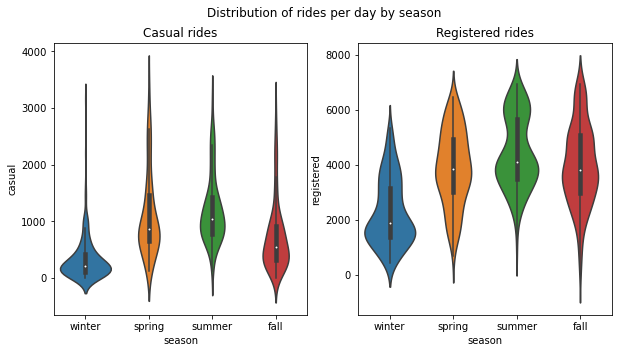

In [13]:
# your code here

fig, axes = plt.subplots(1, 2, sharey=False, sharex=True, figsize=(10, 5))
sns.violinplot(x='season', y='casual', data=bikes_by_day, ax=axes[0])
fig.suptitle("Distribution of rides per day by season")
axes[0].set_title('Casual rides')
axes[0].set_xticklabels(['winter', 'spring', 'summer', 'fall'])
sns.violinplot(x='season', y='registered', data=bikes_by_day, ax=axes[1])
axes[1].set_title('Registered rides')
axes[1].set_xticklabels(['winter', 'spring', 'summer', 'fall'])
plt.show()

<HR>
It seems people dislike riding bikes in the winter, for both casual and registered rides. In both cases, summer appears to have more rides, but it's close to spring and fall.
<HR>

#### 2.3 What percentage of rentals are made by casual riders or registered riders ...

In [14]:
# your code here

df = bikes_by_day.groupby('weekday').agg({
    'casual': 'sum',
    'registered': 'sum',
    'counts': 'sum'
})
df.casual /= df.counts
df.registered /= df.counts
df[['casual', 'registered']]

,casual,registered
weekday,,
0,0.316469,0.683531
1,0.155397,0.844603
2,0.123304,0.876696
3,0.121170,0.878830
4,0.126619,0.873381
5,0.160393,0.839607
6,0.321996,0.678004


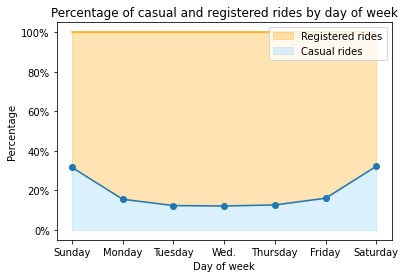

In [15]:
fig, ax = plt.subplots()
ax.plot(df.index, [1]*len(df), color='orange')
ax.fill_between(df.index, [1]*len(df), df.casual, alpha=0.3, label='Registered rides', color='orange')
ax.plot(df.index, df.casual, marker='o')
ax.fill_between(df.index, df.casual, alpha=0.3, label='Casual rides', color='lightskyblue')
ax.set_title('Percentage of casual and registered rides by day of week')
ax.set_xlabel('Day of week')
ax.set_ylabel('Percentage')
ax.legend(loc='upper right')
ax.set_yticklabels(['fill', '0%', '20%', '40%', '60%', '80%', '100%'])
ax.set_xticklabels(['fill', 'Sunday', 'Monday', 'Tuesday', 'Wed.', 'Thursday', 'Friday', 'Saturday'])
plt.show()

<HR>
We can see that, in the weekends, casual rides increase their share. Maybe it's because: less people is going to work or school during these days, and registered rides is most likely to be used for commute; people who use bikes for recreation tend to do it in weekends, most likely with casual rides.<HR>

#### 2.4 How is the distribution of total number of bike rentals different ...

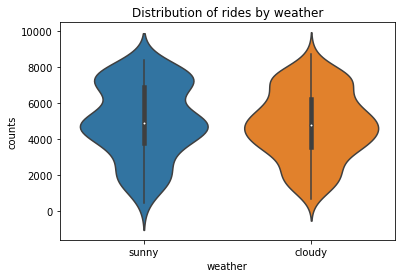

In [16]:
# your code here
fig, ax = plt.subplots()
sns.violinplot(
    x='weather',
    y='counts',
    data=bikes_by_day[(bikes_by_day.weather == 1) | (bikes_by_day.weather == 2)],
    ax=ax
)
ax.set_title('Distribution of rides by weather')
ax.set_xticklabels(['sunny', 'cloudy'])
plt.show()

In general, sunny days has slightly more rides than cloudy days, because of greater median and quantiles.

#### 2.5 Visualize how the total number of rides per day ...

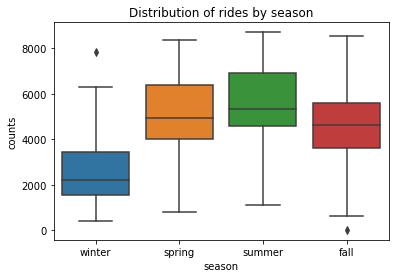

In [17]:
# your code here

fig, ax = plt.subplots()
sns.boxplot(x='season', y='counts', data=bikes_by_day, ax=ax)
ax.set_title("Distribution of rides by season")
ax.set_xticklabels(['winter', 'spring', 'summer', 'fall'])
plt.show()

In [18]:
# Outlier in the winter
bikes_by_day[(bikes_by_day.counts > 7000) & (bikes_by_day.season == 1)]

,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
dteday,,,,,,,,,,
2012-03-17,6,2,1,0.514167,0.505046,0.110704,0.755833,3155,4681,7836


In [19]:
# Verify this outlier
bikes_df[bikes_df.dteday == '2012-03-17']

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
10461,2012-03-17,1,0,0,6,0,2,0.44,0.4394,0.94,0.0896,13,87,1,3,100
10462,2012-03-17,1,1,0,6,0,2,0.44,0.4394,0.94,0.0000,12,57,1,3,69
10463,2012-03-17,1,2,0,6,0,2,0.44,0.4394,0.88,0.0000,10,32,1,3,42
10464,2012-03-17,1,3,0,6,0,2,0.44,0.4394,0.88,0.0000,2,24,1,3,26
10465,2012-03-17,1,4,0,6,0,2,0.42,0.4242,0.94,0.0000,0,2,1,3,2
10466,2012-03-17,1,5,0,6,0,2,0.42,0.4242,0.94,0.0896,5,3,1,3,8
10467,2012-03-17,1,6,0,6,0,2,0.42,0.4242,0.94,0.1940,1,29,1,3,30
10468,2012-03-17,1,7,0,6,0,2,0.40,0.4091,1.00,0.1343,29,57,1,3,86
10469,2012-03-17,1,8,0,6,0,2,0.42,0.4242,0.94,0.1045,63,155,1,3,218
10470,2012-03-17,1,9,0,6,0,2,0.44,0.4394,0.88,0.0896,104,217,1,3,321


In [20]:
# Outlier in the fall
bikes_by_day[(bikes_by_day.counts < 500) & (bikes_by_day.season == 4)]

,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
dteday,,,,,,,,,,
2012-10-29,1,3,4,0.44,0.4394,0.3582,0.88,2,20,22


In [21]:
# Verify this outlier
bikes_df[bikes_df.dteday == '2012-10-29']

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
15883,2012-10-29,4,0,0,1,1,3,0.44,0.4394,0.88,0.3582,2,20,1,10,22


<HR>
We see the same distributions of rides than we saw in casual and registered rides before: less rides in the winter, summer with more rides, but spring and fall close to summer.

There're two outliers, as can be seen in the graph. Searching for them, we find:
- 2012-03-17 had more rides than winter is usual to have. Besides this day being Saturday with good climate conditions for riding, it was St. Patricks Day, with so president [Obama going to a bar to celebrate](https://www.huffpostbrasil.com/entry/obama-st-patricks-day_n_1355563?ri18n=true).
- 2012-10-29 had less rides than usually for a day in the fall. Although it was Monday, it had rides only in the first hour. It's because Washington DC [shut down because of hurricane Sandy](https://www.theguardian.com/world/2012/oct/29/washington-dc-shutdown-hurricane-sandy).
    
<HR>

<div class='exercise'> <b> Question 3: Prepare the data for Regression </b> </div>

**3.1** Visualize and describe inter-dependencies among the following variables: `weekday`, `season`, `month`,`weather`, `temp`, `atemp`, `hum`, `windspeed`, `casual`,`registered`, `counts`. Note and comment on any strongly related variables.

**3.2** Convert the categorical attributes into multiple binary attributes using **one-hot encoding**. 


**3.3** Split the initial `bikes_df` dataset (with hourly data about rentals) into train and test sets. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm. We ask you to create your train and test sets, but for consistency and easy checking we ask that, for the rest of this problem set, you use the train and test set provided in the question below.

**3.4** Read `data/BSS_train.csv` and `data/BSS_test.csv` into dataframes `BSS_train` and `BSS_test`, respectively. After checking your train and test datasets for accuracy, remove the `dteday` column from both train and test dataset. We do not need it, and its format cannot be used for analysis. Also, remove any predictors that would make predicting the `count` trivial.

**3.5** Calculate the **Pearson correlation** coefficients between all the features. Visualize the matrix using a heatmap. Which predictors have a positive correlation with the number of bike rentals? For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Identify pairs of predictors with collinearity >0.7.

#### Hints: 
- You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.



#### Answers

#### 3.1 Visualize and describe inter-dependencies  ... 

In [22]:
columns = ['weekday', 'season', 'month', 'weather', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'counts']
matrix = bikes_df[columns].to_numpy()
correlations = np.corrcoef(matrix.transpose())
corr_df = pd.DataFrame(
    correlations,
    columns=columns,
    index=columns
)
corr_df.style.applymap(lambda x: 'background-color: green' if np.abs(x) > 0.6 and np.round(x, 6) != 1 else '')

,weekday,season,month,weather,temp,atemp,hum,windspeed,casual,registered,counts
weekday,1.000000,-0.002335,0.010400,0.003311,-0.001795,-0.008821,-0.037158,0.011502,0.032721,0.021578,0.026900
season,-0.002335,1.000000,0.830386,-0.014524,0.312025,0.319380,0.150625,-0.149773,0.120206,0.174226,0.178056
month,0.010400,0.830386,1.000000,0.005400,0.201691,0.208096,0.164411,-0.135386,0.068457,0.122273,0.120638
weather,0.003311,-0.014524,0.005400,1.000000,-0.102640,-0.105563,0.418130,0.026226,-0.152628,-0.120966,-0.142426
temp,-0.001795,0.312025,0.201691,-0.102640,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361,0.404772
atemp,-0.008821,0.319380,0.208096,-0.105563,0.987672,1.000000,-0.051918,-0.062336,0.454080,0.332559,0.400929
hum,-0.037158,0.150625,0.164411,0.418130,-0.069881,-0.051918,1.000000,-0.290105,-0.347028,-0.273933,-0.322911
windspeed,0.011502,-0.149773,-0.135386,0.026226,-0.023125,-0.062336,-0.290105,1.000000,0.090287,0.082321,0.093234
casual,0.032721,0.120206,0.068457,-0.152628,0.459616,0.454080,-0.347028,0.090287,1.000000,0.506618,0.694564
registered,0.021578,0.174226,0.122273,-0.120966,0.335361,0.332559,-0.273933,0.082321,0.506618,1.000000,0.972151


<HR>
    
There exists strong correlations between `month` and `season` (which is obvious), between `temp` and `atemp` (which is expected too), between `casual` and `counts` (which is obvious too), and between `counts` and `registered`.
<HR>

#### 3.2 Convert the categorical attributes  ....

In [23]:
# your code here

cat_bikes_df = pd.get_dummies(bikes_df, columns=['season', 'weekday', 'weather', 'month'], drop_first=True)
cat_bikes_df.sample(5)

,dteday,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
11160,2012-04-15,5,0,0,0.50,0.4848,0.68,0.1642,4,6,...,0,1,0,0,0,0,0,0,0,0
16578,2012-11-28,12,0,1,0.34,0.3030,0.42,0.3881,19,189,...,0,0,0,0,0,0,0,0,1,0
2582,2011-04-22,12,0,1,0.34,0.3333,0.76,0.1343,19,61,...,0,1,0,0,0,0,0,0,0,0
11515,2012-04-30,0,0,1,0.44,0.4394,0.72,0.1045,12,36,...,0,1,0,0,0,0,0,0,0,0
6844,2011-10-17,18,0,1,0.56,0.5303,0.60,0.0000,49,469,...,0,0,0,0,0,0,0,1,0,0


#### 3.3 Split the initial bikes_df dataset...

In [24]:
# your code here

train, test = train_test_split(bikes_df, stratify=bikes_df.month)

<HR>
    
`train_test_split` is a good function from `sklearn` to split data into train and test. We want to stratify the data with the months because we don't want train or test data to have sub or super representation of some month, something that can affect our models.
    
<HR>

#### 3.4  Read `data/BSS_train.csv` and `data/BSS_test.csv` into ...

In [25]:
# your code here

BSS_train = pd.read_csv('data/BSS_train.csv')
BSS_test = pd.read_csv('data/BSS_test.csv')

In [26]:
# Sample seems to be accurated
BSS_train.sample(5)

,Unnamed: 0,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
1104,1402,2011-03-03,17,0,0,1,0.26,0.3030,0.22,0.0000,...,0,0,0,0,1,0,0,0,0,0
1458,1830,2011-03-22,0,0,0,1,0.46,0.4545,0.88,0.1940,...,0,0,1,0,0,0,0,0,0,0
11866,14831,2012-09-15,4,0,1,0,0.60,0.5909,0.69,0.3582,...,0,0,0,0,0,0,1,1,0,0
13292,16619,2012-11-30,6,0,1,1,0.20,0.2576,0.86,0.0000,...,0,0,0,0,0,1,0,0,0,0
4699,5916,2011-09-09,1,0,0,1,0.62,0.5152,1.00,0.1642,...,0,0,0,0,0,1,0,1,0,0


In [27]:
# Variables seem to be accurated
BSS_train.columns

Index(['Unnamed: 0', 'dteday', 'hour', 'holiday', 'year', 'workingday', 'temp',
       'atemp', 'hum', 'windspeed', 'casual', 'registered', 'counts', 'spring',
       'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm'],
      dtype='object')

In [28]:
# Describe seems to be accurated
BSS_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,13903.0,8707.333166,5012.167209,0.00,4360.5000,8721.0000,13051.5000,17378.0000
hour,13903.0,11.529454,6.917884,0.00,6.0000,11.0000,18.0000,23.0000
holiday,13903.0,0.029274,0.168580,0.00,0.0000,0.0000,0.0000,1.0000
year,13903.0,0.504567,0.499997,0.00,0.0000,1.0000,1.0000,1.0000
workingday,13903.0,0.680644,0.466244,0.00,0.0000,1.0000,1.0000,1.0000
temp,13903.0,0.496732,0.192699,0.02,0.3400,0.5000,0.6600,1.0000
atemp,13903.0,0.475426,0.171951,0.00,0.3333,0.4848,0.6212,1.0000
hum,13903.0,0.629051,0.193100,0.00,0.4800,0.6300,0.7800,1.0000
windspeed,13903.0,0.190025,0.122009,0.00,0.1045,0.1940,0.2537,0.8507
casual,13903.0,35.414515,48.838431,0.00,4.0000,16.0000,48.0000,367.0000


In [29]:
# The same for test data
BSS_test.sample(5)

,Unnamed: 0,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
3461,17322,2012-12-29,15,0,1,0,0.24,0.2424,0.87,0.0000,...,1,0,0,0,0,0,1,1,0,0
197,913,2011-02-10,14,0,0,1,0.20,0.1818,0.27,0.2836,...,0,0,0,0,1,0,0,0,0,0
902,4453,2011-07-09,11,0,0,0,0.78,0.6970,0.46,0.2985,...,0,0,0,0,0,0,1,0,0,0
2318,11547,2012-05-01,8,0,1,1,0.52,0.5000,0.94,0.2836,...,0,0,1,0,0,0,0,1,0,0
2575,12765,2012-06-21,2,0,1,1,0.72,0.6970,0.79,0.1045,...,0,0,0,0,1,0,0,0,0,0


In [30]:
BSS_test.columns

Index(['Unnamed: 0', 'dteday', 'hour', 'holiday', 'year', 'workingday', 'temp',
       'atemp', 'hum', 'windspeed', 'casual', 'registered', 'counts', 'spring',
       'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm'],
      dtype='object')

In [31]:
BSS_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,3476.0,8615.672612,5036.486147,6.0000,4270.5000,8562.5000,12957.2500,17376.0000
hour,3476.0,11.615938,6.901033,0.0000,6.0000,12.0000,17.0000,23.0000
holiday,3476.0,0.026755,0.161389,0.0000,0.0000,0.0000,0.0000,1.0000
year,3476.0,0.494534,0.500042,0.0000,0.0000,0.0000,1.0000,1.0000
workingday,3476.0,0.691024,0.462138,0.0000,0.0000,1.0000,1.0000,1.0000
temp,3476.0,0.498009,0.192006,0.0200,0.3400,0.5000,0.6600,0.9600
atemp,3476.0,0.477173,0.171464,0.0303,0.3333,0.4848,0.6212,0.9545
hum,3476.0,0.619940,0.192104,0.0000,0.4700,0.6200,0.7800,1.0000
windspeed,3476.0,0.190389,0.123672,0.0000,0.1045,0.1940,0.2537,0.8060
casual,3476.0,36.722957,51.122565,0.0000,4.0000,17.0000,48.2500,354.0000


In [32]:
# Drop some columns
BSS_train.drop(columns=['Unnamed: 0', 'dteday', 'casual', 'registered'], inplace=True)
BSS_test.drop(columns=['Unnamed: 0', 'dteday', 'casual', 'registered'], inplace=True)

In [33]:
# The test_size
len(BSS_test)/(len(BSS_test) + len(BSS_train))

0.20001150814201046

In [34]:
# Percentage of February months in test data (very close to test_size)
(BSS_test.Feb == 1).sum()/((BSS_test.Feb == 1).sum() + (BSS_train.Feb == 1).sum())

0.19985085756897839

<HR>
    
Train and test data seem to be accurated, because a sample, the column names and the describe of the DataFrame seem to be reasonable. Besides that, data seems to be stratified too (look at the sanity check with February month). The columns `Unnamed: 0`, `dteday` were removed, as well as the columns `casual` and `registered`, because they would make the prediction of `counts` trivial.
<HR>

#### 3.5 Calculate the **Pearson correlation** ....

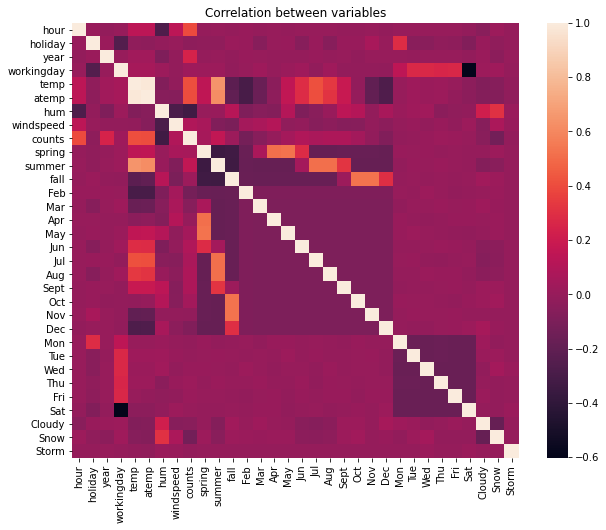

In [35]:
# your code here

# The heatmap

correlations = np.corrcoef(BSS_train.to_numpy().transpose())
df = pd.DataFrame(
    correlations,
    columns=BSS_train.columns,
    index=BSS_train.columns
)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df, ax=ax)
ax.set_title('Correlation between variables')
plt.show()

In [36]:
# The positive correlations with count
df2 = df.iloc[df.counts.argsort()].iloc[::-1]
df2[df2.counts > 0][['counts']]

,counts
counts,1.000000
temp,0.406155
atemp,0.401119
hour,0.394167
year,0.243886
summer,0.159319
Jun,0.094448
windspeed,0.093981
Aug,0.085847
Sept,0.080225


In [37]:
# Pairs of predictors with abs(correlation) > 0.7
np.where((np.abs(df.to_numpy()) > 0.7) & (np.round(df.to_numpy(), 6) != 1))

(array([4, 5]), array([5, 4]))

In [38]:
# It's obvious:
print(df.iloc[4, 5], df.index[4], df.columns[5])

0.987407710819568 temp atemp


<HR>

`temp`, `atemp`, `hour` and `year` are the variables with the strongest positive correlations with `counts`. The only pair of variables with correlation $> 0.7$ (in absolute value) is `temp` and `atemp`.
<HR>

<div class='exercise'> <b> Question 4: Multiple Linear Regression </b> </div>

**4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms), and report its $R^2$ score on the train and test sets.


**4.2** Find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value < 0.05). Comment on the results.


**4.3** Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is slightly different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms? 

### Answers
#### 4.1 Use statsmodels to fit a ... 


In [39]:
# your code here
X_train = sm.add_constant(BSS_train.drop(columns='counts').to_numpy())
X_test = sm.add_constant(BSS_test.drop(columns='counts').to_numpy())
y_train = BSS_train.counts.to_numpy()
y_test = BSS_test.counts.to_numpy()

model = sm.OLS(y_train, X_train).fit()
print('Train data R² score: {:.4f}\nTest data R² score:  {:.4f}'.format(
    r2_score(y_train, model.predict()),
    r2_score(y_test, model.predict(X_test))
))

Train data R² score: 0.4065
Test data R² score:  0.4064


#### 4.2 Find out which of estimated coefficients ...

In [40]:
# your code here

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     316.8
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        22:34:43   Log-Likelihood:                -88306.
No. Observations:               13903   AIC:                         1.767e+05
Df Residuals:                   13872   BIC:                         1.769e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.0830      8.641     -2.440      0.015     -38.020      -4.146
x1             7.2214      0.184     39.144      0.000       6.860       7.583
x2           -18.0958      6.597     -2.743      0.006     -31.027      -5.165
x3            76.3519      2.380     32.084      0.000      71.687      81.017
x4            11.3178      2.751      4.114      0.000       5.926      16.710
x5           333.2482     44.162      7.546      0.000     246.684     419.812
x6            74.6312     46.207      1.615      0.106     -15.940     165.202
x7          -205.4959      7.801    -26.343      0.000    -220.786    -190.205
x8            22.5168     10.753      2.094      0.036       1.439      43.595
x9            43.1541      7.417      5.818      0.000      28.615      57.693
x10           29.5426      8.773      3.367      0.001      12.346      46.739
x11           68.5953      7.492      9.156      0.000      53.911      83.280
x12           -7.6430      5.966     -1.281      0.200     -19.336       4.050
x13          -11.6737      6.665     -1.752      0.080     -24.737       1.390
x14          -41.5244      9.878     -4.204      0.000     -60.886     -22.163
x15          -33.2927     10.543     -3.158      0.002     -53.958     -12.628
x16          -65.8039     10.716     -6.141      0.000     -86.809     -44.799
x17          -93.4805     12.086     -7.734      0.000    -117.171     -69.789
x18          -59.2081     11.832     -5.004      0.000     -82.401     -36.015
x19          -16.0517     10.575     -1.518      0.129     -36.780       4.676
x20          -16.1602      9.865     -1.638      0.101     -35.497       3.177
x21          -25.8732      9.527     -2.716      0.007     -44.547      -7.199
x22          -10.2043      7.614     -1.340      0.180     -25.128       4.719
x23           -2.6601      2.978     -0.893      0.372      -8.498       3.177
x24           -6.1425      3.208     -1.915      0.056     -12.430       0.145
x25            2.2964      3.183      0.721      0.471      -3.943       8.536
x26           -3.1611      3.185     -0.993      0.321      -9.404       3.082
x27            2.8892      3.186      0.907      0.364      -3.355       9.133
x28           14.9459      4.382      3.411      0.001       6.357      23.535
x29            6.7868      2.900      2.341      0.019       1.103      12.470
x30          -28.2859      4.819     -5.870      0.000     -37.731     -18.841
x31           42.3569     98.377      0.431      0.667    -150.475     235.189
==============================================================================
Omnibus:                     2831.359   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5657.789
Skew:                           1.224   Prob(JB):                         0.00
Ku

In [41]:
# The statistically significant (with level of 5%) estimated coefficients

list(np.array(['intercept']+list(BSS_train.drop(columns='counts').columns))[model.pvalues < 0.05])

['intercept',
 'hour',
 'holiday',
 'year',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'spring',
 'summer',
 'fall',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Nov',
 'Sat',
 'Cloudy',
 'Snow']

In [42]:
# The statistically insignificant (with level of 5%) estimated coefficients

list(np.array(['intercept']+list(BSS_train.drop(columns='counts').columns))[model.pvalues >= 0.05])

['atemp',
 'Feb',
 'Mar',
 'Sept',
 'Oct',
 'Dec',
 'Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Storm']

We see that not all features have coefficients statistically significant (with level of 5%), but the majority of them have. `atemp` has statistically insignificant coefficient (maybe because there's already `temp`?), many months and `Storm` (maybe because of few data?).

#### 4.3 Make a plot of residuals of the fitted ...

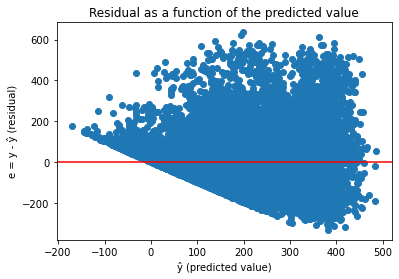

In [43]:
plt.scatter(model.predict(), model.resid)
plt.xlabel('ŷ (predicted value)')
plt.ylabel('e = y - ŷ (residual)')
plt.title('Residual as a function of the predicted value')
plt.axhline(0, color='red')
plt.show()

If `counts` variable were a linear function of the other variables, the residuals shoud have the same variance. That is, the residuals should have the same distribution, independently of the predicted value. It's not what we see above, because variance is changing. It reveals a non-linear relationship.

<div class='exercise'> <b>Question 5: Subset Selection </b> </div>

**5.1** Implement forward step-wise  selection to select a minimal subset of predictors that are related to the response variable: 

We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. 

**5.2** Do these methods eliminate one or more of the colinear predictors (if any) identified in Question 3.5?  If so, which ones. Briefly explain (3 or fewer sentences) why you think this may be the case.

**5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Question 4 using all predictors?

### Answers

#### 5.1  Implement forward step-wise ....

In [44]:
# your code here

def forward_selection(df_train, target):
    models = []
    variables = list(df_train.drop(columns=target).columns)
    J = len(variables)
    y_train = df_train[target].to_numpy()
    n = len(y_train)
    
    X_train = np.ones((n, 1))
    model_0 = sm.OLS(y_train, X_train).fit()
    mse = np.mean((y_train - model_0.predict())**2)
    models.append({'model': model_0, 'variables': [], 'bic': model_0.bic})
    
    for k in range(1, J+1):
        model_candidates = []
        for variable in variables:
            predictors = models[-1]['variables'].copy()
            predictors.append(variable)
            X_train = df_train[predictors].to_numpy()
            X_train = sm.add_constant(X_train)
            model = sm.OLS(y_train, X_train).fit()
            mse = np.mean((y_train - model.predict())**2)
            model_candidates.append({'model': model, 'variables': predictors, 'bic': model.bic})
        model = min(model_candidates, key=lambda x: x['bic'])
        models.append(model)
        variables.remove(model['variables'][-1])
        
    return min(models, key=lambda x: x['bic'])

my_model = forward_selection(BSS_train, 'counts')
my_model

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f40db82b4c0>,
 'variables': ['temp',
  'hour',
  'year',
  'hum',
  'fall',
  'Jul',
  'Snow',
  'Aug',
  'Jun',
  'holiday',
  'spring'],
 'bic': 176790.38694346516}

<HR>

The selected subset is:
`temp`, `hour`, `year`, `hum`, `fall`, `Jul`, `Snow`, `Aug`, `Jun`, `holiday`, `spring`.
<HR>

#### 5.2 Do these methods eliminate ...

<HR>

The coefficients positive related to `counts` that were eliminated are:
`atemp`, `summer`, `windspeed`, `Sept`, `May`, `Oct`, `workingday`, `Thu`, `Fri`, `Wed`, `Sat`.

Maybe it happened because some of them has, despite of positive correlation, week correlation, and there are negative correlated coefficients that are stronger. Maybe they're already represented by another feature.
<HR>

#### 5.3 In each case, fit linear regression  ...

In [45]:
# your code here

my_X_test = sm.add_constant(BSS_test[my_model['variables']].to_numpy())
r2_score(y_test, my_model['model'].predict(my_X_test))

0.40469087705369555

<HR>
    
The test $R^2$ score with all predictors was 0.4064. So the new $R^2$ score is less than that one.
    
It's kind of expected. The $R^2$ score for train data with all predictors was 0.4065, very close to the test one. The $R^2$ for train data with all predictors is an upperbound for $R^2$ in train data (imagine linear regression with less predictors as putting the eliminated coefficients as zero), and it's expected to see $R^2$ on test data less than on train data. So it's reasonable to see this new $R^2$ on test data less than the old one.
<HR>

<div class='exercise'> <b> Question 6: Polynomial Regression </b> </div> 

We will now try to improve the performance of the regression model by including higher-order polynomial terms. 

**6.1** For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a polynomial regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in the previous question? Using a $t$-tests, find out which of the estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

In [46]:
# your code here

transform = PolynomialFeatures(4, include_bias=False)
X_train_transformed = np.ones((X_train.shape[0], 1))
for feature in range(1, X_train.shape[1]):
    transformed = transform.fit_transform(X_train[:, feature][..., np.newaxis])
    X_train_transformed = np.concatenate((X_train_transformed, transformed), axis=1)
    
model = sm.OLS(y_train, X_train_transformed).fit()

X_test_transformed = np.ones((X_test.shape[0], 1))
for feature in range(1, X_test.shape[1]):
    transformed = transform.fit_transform(X_test[:, feature][..., np.newaxis])
    X_test_transformed = np.concatenate((X_test_transformed, transformed), axis=1)

print('Test data R² score: {:.4f}'.format(r2_score(y_test, model.predict(X_test_transformed))))

Test data R² score: 0.5519


In [47]:
# Statistically significant (level of 5%) coefficients

polynomial_features = ['intercept']
for feature in BSS_train.drop(columns='counts').columns:
    for i in range(1, 5):
        polynomial_features.append('{}^{}'.format(feature, i))
print(list(np.array(polynomial_features)[model.pvalues < 0.05]))

['hour^1', 'hour^2', 'hour^4', 'year^1', 'year^2', 'year^3', 'year^4', 'workingday^1', 'workingday^2', 'workingday^3', 'workingday^4', 'temp^3', 'temp^4', 'hum^2', 'hum^3', 'hum^4', 'windspeed^3', 'windspeed^4', 'spring^1', 'spring^2', 'spring^3', 'spring^4', 'summer^1', 'summer^2', 'summer^3', 'summer^4', 'fall^1', 'fall^2', 'fall^3', 'fall^4', 'Feb^1', 'Feb^2', 'Feb^3', 'Feb^4', 'Mar^1', 'Mar^2', 'Mar^3', 'Mar^4', 'Apr^1', 'Apr^2', 'Apr^3', 'Apr^4', 'May^1', 'May^2', 'May^3', 'May^4', 'Jun^1', 'Jun^2', 'Jun^3', 'Jun^4', 'Sept^1', 'Sept^2', 'Sept^3', 'Sept^4', 'Oct^1', 'Oct^2', 'Oct^3', 'Oct^4', 'Mon^1', 'Mon^2', 'Mon^3', 'Mon^4', 'Fri^1', 'Fri^2', 'Fri^3', 'Fri^4', 'Sat^1', 'Sat^2', 'Sat^3', 'Sat^4', 'Cloudy^1', 'Cloudy^2', 'Cloudy^3', 'Cloudy^4', 'Snow^1', 'Snow^2', 'Snow^3', 'Snow^4']


<HR>

We achieved the best test $R^2$ score: 0.5519. The list of statistically significant coefficients are list above. Almost all features selected in the previous question have a polynomial term with statistically significance (level of 5%), as can be seen above.
<HR>

#  Written Report to the Administrators
<br>

<div class='exercise'> <b> Question 7 </b> </div>

Write a short summary report, intended for the administrators of the company, to address two major points (can be written as two large paragraphs):

1. How to predict ridership well (which variables are important, when is ridership highest/lowest, etc.).

2. Suggestions on how to increase the system revenue (what additional services to provide, when to give discounts, etc.).
 
Include your report below. The report should not be longer than 300 words and should include a maximum of 3 figures. 

### Answers
#### 7
<HR>
    
Prediction of number of rides is a very important task when dealing with bike sharing services. We found some interesting insights in our analysis.
    
The most part or the rides is done by registered clientes in commute time, that is, people is using for going to work or school.
    
![alt text](fig/fig_1.png) 
    
In general, the trend is: rides begin with the morning, end with the night and vanish at dawn, with peaks of use in commute times. On holidays, we also see that, but these peaks are shorter and casual rides are greater. We also see that weather doesn't affect as much as we could think: people still ride bikes in snow and thunderstorm days, although the number is less. People ride bikes less in winter, and in the other seasons the numbers are very close.
    
![alt text](fig/fig_2.png)    

During weekdays, approx. 15% of the rides are casual rides, against 35% in weekends.
    
When dealing with linear regression models, a good subset of features is `temp`, `hour`, `year`, `hum`, `fall`, `Jul`, `Snow`, `Aug`, `Jun`, `holiday`, `spring`. But we have to say that we observed non-linear relationships with data, so maybe it's better to use polynomial regressions, which we observe to perform better.
    
Our tips are based in three aspects:
- **Raise rides when there're few of them.** In the winter, people use less the bikes, so it's a good ideia to offer discounts during this season.
- **Take advantage of loyalty.** We saw people use your service a lot for commute, that is, people use it everyday. Offer discounts and advantages for these users is a good idea, in order to attract more people and to loyalty them. 
- **Offer more bikes when it's being heavy used.** It happens during commute time and in seasons like the summer, and it’s good to make sure there’s no shortage of bicycles.
<HR>

